In [1]:
import scanpy as sc

/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing 

In [2]:
adata = sc.read_h5ad("./sdvelo_subset_granule.h5ad")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the potential model
class PotentialNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(PotentialNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Output is scalar potential
        )

    def forward(self, x):
        return self.net(x)

In [4]:
model = PotentialNN(input_dim=2000)

data_x = torch.Tensor(adata.layers["spliced"].toarray())
data_y = torch.Tensor(adata.layers["sde_velocity"])

In [5]:
adata

AnnData object with n_obs × n_vars = 2291 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'latent_time', 'sde_velocity_self_transition', 'sde_velocity_length', 'sde_velocity_confidence', 'sde_velocity_confidence_transition'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_sigma_1', 'fit_sigma_2'
    uns: 'clusters_colors', 'log1p', 'neighbors', 'pca', 'sde_velocity_graph', 'sde_velocity_graph_neg', 'sde_velocity_params'
    obsm: 'X_pca', 'X_umap', 'sde_velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'pred_s', 'pred_u', 'sde_velocity', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [6]:
import torch
from torch.autograd import grad

def compute_gradient(potential, x):
    grad_outputs = torch.ones_like(potential)
    gradients = grad(outputs=potential, inputs=x, grad_outputs=grad_outputs, create_graph=True)[0]
    return gradients

In [7]:
from tqdm import tqdm
import torch.optim as optim

# Set training parameters
epochs = 1000
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

# Ensure gradients can be calculated for input data
data_x.requires_grad_()
data_y.requires_grad_()

# Training loop with tqdm progress bar
for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()
    optimizer.zero_grad()

    # Compute potential and gradient
    potentials = model(data_x)
    gradients = compute_gradient(potentials, data_x)

    # Compute loss
    loss = torch.mean((data_y + gradients) ** 2)
    loss.backward()
    optimizer.step()

    # Print loss every 100 epochs
    tqdm.write(f"Epoch {epoch}, Loss: {loss.item()}")


Training Progress:   0%|          | 5/1000 [00:00<00:40, 24.85it/s]

Epoch 0, Loss: 0.0026184062007814646
Epoch 1, Loss: 0.0026179554406553507
Epoch 2, Loss: 0.0026175284292548895
Epoch 3, Loss: 0.002617107704281807
Epoch 4, Loss: 0.00261670327745378
Epoch 5, Loss: 0.002616303041577339


Training Progress:   1%|▏         | 13/1000 [00:00<00:34, 28.90it/s]

Epoch 6, Loss: 0.0026159260887652636
Epoch 7, Loss: 0.002615552395582199
Epoch 8, Loss: 0.002615183126181364
Epoch 9, Loss: 0.0026148289907723665
Epoch 10, Loss: 0.002614472759887576
Epoch 11, Loss: 0.0026141211856156588
Epoch 12, Loss: 0.002613761695101857


Training Progress:   2%|▏         | 19/1000 [00:00<00:34, 28.62it/s]

Epoch 13, Loss: 0.0026134124491363764
Epoch 14, Loss: 0.0026130485348403454
Epoch 15, Loss: 0.00261269835755229
Epoch 16, Loss: 0.002612349344417453
Epoch 17, Loss: 0.002611995441839099
Epoch 18, Loss: 0.002611624775454402


Training Progress:   2%|▎         | 25/1000 [00:00<00:33, 28.74it/s]

Epoch 19, Loss: 0.0026112559717148542
Epoch 20, Loss: 0.002610885538160801
Epoch 21, Loss: 0.002610495314002037
Epoch 22, Loss: 0.0026101069524884224
Epoch 23, Loss: 0.0026096946094185114
Epoch 24, Loss: 0.0026092936750501394


Training Progress:   3%|▎         | 28/1000 [00:01<00:33, 28.94it/s]

Epoch 25, Loss: 0.002608878305181861
Epoch 26, Loss: 0.002608472015708685
Epoch 27, Loss: 0.0026080524548888206
Epoch 28, Loss: 0.0026076477952301502


Training Progress:   4%|▎         | 35/1000 [00:01<00:37, 26.06it/s]

Epoch 29, Loss: 0.0026072240434587
Epoch 30, Loss: 0.002606816589832306
Epoch 31, Loss: 0.0026063555851578712
Epoch 32, Loss: 0.002605920657515526
Epoch 33, Loss: 0.0026054768823087215
Epoch 34, Loss: 0.0026050000451505184
Epoch 35, Loss: 0.0026045143604278564


Training Progress:   4%|▍         | 41/1000 [00:01<00:34, 27.52it/s]

Epoch 36, Loss: 0.0026040368247777224
Epoch 37, Loss: 0.002603542059659958
Epoch 38, Loss: 0.0026030302979052067
Epoch 39, Loss: 0.0026024887338280678
Epoch 40, Loss: 0.0026019273791462183
Epoch 41, Loss: 0.002601371146738529


Training Progress:   5%|▍         | 49/1000 [00:01<00:32, 29.03it/s]

Epoch 42, Loss: 0.0026007851120084524
Epoch 43, Loss: 0.002600177191197872
Epoch 44, Loss: 0.002599593484774232
Epoch 45, Loss: 0.002598957857117057
Epoch 46, Loss: 0.0025983229279518127
Epoch 47, Loss: 0.0025976228062063456
Epoch 48, Loss: 0.00259693362750113


Training Progress:   5%|▌         | 52/1000 [00:01<00:32, 29.15it/s]

Epoch 49, Loss: 0.0025962393265217543
Epoch 50, Loss: 0.0025955005548894405
Epoch 51, Loss: 0.0025947620160877705
Epoch 52, Loss: 0.0025940092746168375


Training Progress:   6%|▌         | 58/1000 [00:02<00:39, 23.56it/s]

Epoch 53, Loss: 0.0025932062417268753
Epoch 54, Loss: 0.0025923929642885923
Epoch 55, Loss: 0.002591567113995552
Epoch 56, Loss: 0.002590736374258995
Epoch 57, Loss: 0.002589849755167961


Training Progress:   6%|▋         | 64/1000 [00:02<00:38, 24.46it/s]

Epoch 58, Loss: 0.002588964533060789
Epoch 59, Loss: 0.002588114468380809
Epoch 60, Loss: 0.0025871647521853447
Epoch 61, Loss: 0.0025861787144094706
Epoch 62, Loss: 0.0025852415710687637
Epoch 63, Loss: 0.0025842308532446623


Training Progress:   7%|▋         | 70/1000 [00:02<00:35, 26.19it/s]

Epoch 64, Loss: 0.0025832075625658035
Epoch 65, Loss: 0.002582205692306161
Epoch 66, Loss: 0.002581134205684066
Epoch 67, Loss: 0.002580034313723445
Epoch 68, Loss: 0.002578903455287218
Epoch 69, Loss: 0.002577792154625058


Training Progress:   8%|▊         | 76/1000 [00:02<00:33, 27.35it/s]

Epoch 70, Loss: 0.002576632658019662
Epoch 71, Loss: 0.0025754072703421116
Epoch 72, Loss: 0.002574192127212882
Epoch 73, Loss: 0.002572854747995734
Epoch 74, Loss: 0.0025715783704072237
Epoch 75, Loss: 0.0025702782440930605


Training Progress:   8%|▊         | 79/1000 [00:03<00:39, 23.35it/s]

Epoch 76, Loss: 0.0025689913891255856
Epoch 77, Loss: 0.0025675820652395487
Epoch 78, Loss: 0.002566136885434389
Epoch 79, Loss: 0.002564741065725684


Training Progress:   8%|▊         | 82/1000 [00:03<00:38, 23.87it/s]

Epoch 80, Loss: 0.002563282148912549
Epoch 81, Loss: 0.0025618132203817368
Epoch 82, Loss: 0.0025602560490369797
Epoch 83, Loss: 0.002558744978159666


Training Progress:   9%|▉         | 88/1000 [00:03<00:47, 19.13it/s]

Epoch 84, Loss: 0.0025570897851139307
Epoch 85, Loss: 0.0025554588064551353
Epoch 86, Loss: 0.002553800819441676
Epoch 87, Loss: 0.002552032470703125


Training Progress:   9%|▉         | 91/1000 [00:03<00:57, 15.88it/s]

Epoch 88, Loss: 0.002550250617787242
Epoch 89, Loss: 0.002548397984355688
Epoch 90, Loss: 0.002546485746279359


Training Progress:  10%|▉         | 95/1000 [00:04<00:55, 16.21it/s]

Epoch 91, Loss: 0.002544576767832041
Epoch 92, Loss: 0.00254264660179615
Epoch 93, Loss: 0.0025406242348253727
Epoch 94, Loss: 0.002538558328524232


Training Progress:  10%|█         | 100/1000 [00:04<00:45, 19.62it/s]

Epoch 95, Loss: 0.0025363732129335403
Epoch 96, Loss: 0.0025342553853988647
Epoch 97, Loss: 0.002532140351831913
Epoch 98, Loss: 0.0025299314875155687
Epoch 99, Loss: 0.0025276655796915293
Epoch 100, Loss: 0.0025253365747630596


Training Progress:  11%|█         | 106/1000 [00:04<00:45, 19.61it/s]

Epoch 101, Loss: 0.002523136092349887
Epoch 102, Loss: 0.002520706970244646
Epoch 103, Loss: 0.0025183947291225195
Epoch 104, Loss: 0.0025159274227917194
Epoch 105, Loss: 0.002513560466468334


Training Progress:  11%|█         | 112/1000 [00:04<00:40, 22.08it/s]

Epoch 106, Loss: 0.0025110170245170593
Epoch 107, Loss: 0.002508376259356737
Epoch 108, Loss: 0.0025057659950107336
Epoch 109, Loss: 0.0025031138211488724
Epoch 110, Loss: 0.0025003175251185894
Epoch 111, Loss: 0.0024975426495075226


Training Progress:  12%|█▏        | 115/1000 [00:05<00:42, 20.89it/s]

Epoch 112, Loss: 0.0024947915226221085
Epoch 113, Loss: 0.0024920417927205563
Epoch 114, Loss: 0.0024891600478440523
Epoch 115, Loss: 0.0024860824923962355


Training Progress:  12%|█▏        | 121/1000 [00:05<00:41, 20.99it/s]

Epoch 116, Loss: 0.0024830664042383432
Epoch 117, Loss: 0.0024801641702651978
Epoch 118, Loss: 0.0024771138560026884
Epoch 119, Loss: 0.0024740395601838827
Epoch 120, Loss: 0.002471011132001877


Training Progress:  13%|█▎        | 127/1000 [00:05<00:37, 23.12it/s]

Epoch 121, Loss: 0.002467940328642726
Epoch 122, Loss: 0.0024646541569381952
Epoch 123, Loss: 0.002461398718878627
Epoch 124, Loss: 0.0024579493328928947
Epoch 125, Loss: 0.0024545839987695217
Epoch 126, Loss: 0.0024512321688234806


Training Progress:  13%|█▎        | 130/1000 [00:05<00:43, 20.12it/s]

Epoch 127, Loss: 0.0024478205014020205
Epoch 128, Loss: 0.002444378100335598
Epoch 129, Loss: 0.0024407494347542524
Epoch 130, Loss: 0.002437205519527197


Epoch 131, Loss: 0.0024335631169378757
Epoch 132, Loss: 0.002429832238703966
Epoch 133, Loss: 0.0024262419901788235
Epoch 134, Loss: 0.002422592369839549
Epoch 135, Loss: 0.0024185122456401587


Training Progress:  14%|█▍        | 139/1000 [00:06<00:37, 23.12it/s]

Epoch 136, Loss: 0.0024144938215613365
Epoch 137, Loss: 0.0024105985648930073
Epoch 138, Loss: 0.0024067689664661884
Epoch 139, Loss: 0.002402703044936061
Epoch 140, Loss: 0.0023985025472939014


Training Progress:  14%|█▍        | 145/1000 [00:06<00:35, 24.10it/s]

Epoch 141, Loss: 0.0023943043779581785
Epoch 142, Loss: 0.0023902556858956814
Epoch 143, Loss: 0.0023860863875597715
Epoch 144, Loss: 0.0023818835616111755
Epoch 145, Loss: 0.0023775019217282534


Training Progress:  15%|█▍        | 148/1000 [00:06<00:39, 21.72it/s]

Epoch 146, Loss: 0.0023729773238301277
Epoch 147, Loss: 0.0023685498163104057
Epoch 148, Loss: 0.002363920910283923
Epoch 149, Loss: 0.002359087811782956


Training Progress:  15%|█▌        | 154/1000 [00:06<00:40, 20.76it/s]

Epoch 150, Loss: 0.002354408847168088
Epoch 151, Loss: 0.0023497154470533133
Epoch 152, Loss: 0.002344816457480192
Epoch 153, Loss: 0.00233990210108459
Epoch 154, Loss: 0.0023348648101091385


Training Progress:  16%|█▌        | 157/1000 [00:06<00:42, 19.86it/s]

Epoch 155, Loss: 0.002329789102077484
Epoch 156, Loss: 0.0023248104844242334
Epoch 157, Loss: 0.002319591585546732


Training Progress:  16%|█▋        | 163/1000 [00:07<00:44, 18.67it/s]

Epoch 158, Loss: 0.002314342651516199
Epoch 159, Loss: 0.0023091041948646307
Epoch 160, Loss: 0.0023037476930767298
Epoch 161, Loss: 0.0022981863003224134
Epoch 162, Loss: 0.002292310819029808


Training Progress:  17%|█▋        | 166/1000 [00:07<00:48, 17.11it/s]

Epoch 163, Loss: 0.002286697505041957
Epoch 164, Loss: 0.0022807149216532707
Epoch 165, Loss: 0.0022747747134417295


Training Progress:  17%|█▋        | 168/1000 [00:07<00:51, 16.14it/s]

Epoch 166, Loss: 0.002268916694447398
Epoch 167, Loss: 0.0022629203740507364
Epoch 168, Loss: 0.002256985055282712
Epoch 169, Loss: 0.002250748686492443


Training Progress:  17%|█▋        | 174/1000 [00:07<00:41, 19.68it/s]

Epoch 170, Loss: 0.0022444811183959246
Epoch 171, Loss: 0.0022381397429853678
Epoch 172, Loss: 0.0022320931311696768
Epoch 173, Loss: 0.002225712640210986
Epoch 174, Loss: 0.002219422720372677
Epoch 175, Loss: 0.0022129674907773733


Training Progress:  18%|█▊        | 180/1000 [00:08<00:35, 23.20it/s]

Epoch 176, Loss: 0.0022065741941332817
Epoch 177, Loss: 0.002199616050347686
Epoch 178, Loss: 0.0021928241476416588
Epoch 179, Loss: 0.0021856913808733225
Epoch 180, Loss: 0.0021784696727991104
Epoch 181, Loss: 0.0021714968606829643


Training Progress:  19%|█▊        | 186/1000 [00:08<00:31, 25.68it/s]

Epoch 182, Loss: 0.0021644283551722765
Epoch 183, Loss: 0.0021570713724941015
Epoch 184, Loss: 0.0021499686408787966
Epoch 185, Loss: 0.0021426090970635414
Epoch 186, Loss: 0.0021352656185626984
Epoch 187, Loss: 0.0021275165490806103


Training Progress:  19%|█▉        | 192/1000 [00:08<00:36, 21.84it/s]

Epoch 188, Loss: 0.002120070159435272
Epoch 189, Loss: 0.002112653339281678
Epoch 190, Loss: 0.002104921732097864
Epoch 191, Loss: 0.0020971358753740788


Training Progress:  20%|█▉        | 198/1000 [00:08<00:33, 23.82it/s]

Epoch 192, Loss: 0.002089644316583872
Epoch 193, Loss: 0.002082021441310644
Epoch 194, Loss: 0.0020742344204336405
Epoch 195, Loss: 0.002066628308966756
Epoch 196, Loss: 0.002058451995253563
Epoch 197, Loss: 0.00205021514557302


Training Progress:  20%|██        | 202/1000 [00:09<00:30, 25.82it/s]

Epoch 198, Loss: 0.0020423780661076307
Epoch 199, Loss: 0.002034420147538185
Epoch 200, Loss: 0.002026438247412443
Epoch 201, Loss: 0.002018042141571641
Epoch 202, Loss: 0.002009914955124259
Epoch 203, Loss: 0.0020016939379274845


Training Progress:  21%|██        | 208/1000 [00:09<00:35, 22.23it/s]

Epoch 204, Loss: 0.001993524841964245
Epoch 205, Loss: 0.00198522862046957
Epoch 206, Loss: 0.001977004110813141
Epoch 207, Loss: 0.0019687367603182793


Training Progress:  21%|██        | 211/1000 [00:09<00:41, 18.95it/s]

Epoch 208, Loss: 0.001960176508873701
Epoch 209, Loss: 0.0019518006592988968
Epoch 210, Loss: 0.001943384064361453


Training Progress:  22%|██▏       | 217/1000 [00:09<00:37, 20.83it/s]

Epoch 211, Loss: 0.0019346781773492694
Epoch 212, Loss: 0.001926047494634986
Epoch 213, Loss: 0.0019174858462065458
Epoch 214, Loss: 0.0019092028960585594
Epoch 215, Loss: 0.0019007595255970955
Epoch 216, Loss: 0.0018922957824543118


Training Progress:  22%|██▏       | 220/1000 [00:09<00:39, 19.58it/s]

Epoch 217, Loss: 0.0018839717376977205
Epoch 218, Loss: 0.0018753857584670186
Epoch 219, Loss: 0.001866817125119269
Epoch 220, Loss: 0.001858186791650951
Epoch 221, Loss: 0.0018495492404326797


Training Progress:  23%|██▎       | 226/1000 [00:10<00:33, 22.87it/s]

Epoch 222, Loss: 0.0018411941127851605
Epoch 223, Loss: 0.0018326732097193599
Epoch 224, Loss: 0.001824119477532804
Epoch 225, Loss: 0.0018157749436795712
Epoch 226, Loss: 0.001807712484151125
Epoch 227, Loss: 0.0017993183573707938


Training Progress:  23%|██▎       | 232/1000 [00:10<00:34, 22.25it/s]

Epoch 228, Loss: 0.0017907705623656511
Epoch 229, Loss: 0.0017824557144194841
Epoch 230, Loss: 0.001774100586771965
Epoch 231, Loss: 0.00176580052357167
Epoch 232, Loss: 0.0017576294485479593
Epoch 233, Loss: 0.0017495839856564999


Training Progress:  24%|██▍       | 238/1000 [00:10<00:37, 20.08it/s]

Epoch 234, Loss: 0.001741453423164785
Epoch 235, Loss: 0.001733453362248838
Epoch 236, Loss: 0.0017256292048841715
Epoch 237, Loss: 0.001717716222628951


Training Progress:  24%|██▍       | 241/1000 [00:10<00:40, 18.94it/s]

Epoch 238, Loss: 0.0017099733231589198
Epoch 239, Loss: 0.0017021306557580829
Epoch 240, Loss: 0.0016944094095379114


Training Progress:  25%|██▍       | 246/1000 [00:11<00:40, 18.45it/s]

Epoch 241, Loss: 0.0016868741950020194
Epoch 242, Loss: 0.0016792303649708629
Epoch 243, Loss: 0.0016717215767130256
Epoch 244, Loss: 0.001664371695369482
Epoch 245, Loss: 0.001657315413467586


Training Progress:  25%|██▍       | 249/1000 [00:11<00:37, 20.22it/s]

Epoch 246, Loss: 0.0016499237390235066
Epoch 247, Loss: 0.0016429271781817079
Epoch 248, Loss: 0.00163599057123065
Epoch 249, Loss: 0.0016293320804834366
Epoch 250, Loss: 0.0016224593855440617


Training Progress:  26%|██▌       | 255/1000 [00:11<00:35, 21.25it/s]

Epoch 251, Loss: 0.0016159182414412498
Epoch 252, Loss: 0.0016094486927613616
Epoch 253, Loss: 0.0016034740256145597
Epoch 254, Loss: 0.0015975863207131624
Epoch 255, Loss: 0.0015915200347080827
Epoch 256, Loss: 0.0015858467668294907


Training Progress:  26%|██▌       | 258/1000 [00:11<00:32, 23.07it/s]

Epoch 257, Loss: 0.0015801030676811934
Epoch 258, Loss: 0.0015744385309517384
Epoch 259, Loss: 0.0015686525730416179


Training Progress:  26%|██▋       | 264/1000 [00:12<00:36, 20.37it/s]

Epoch 260, Loss: 0.0015634674346074462
Epoch 261, Loss: 0.001558590098284185
Epoch 262, Loss: 0.0015537034487351775
Epoch 263, Loss: 0.0015490894438698888
Epoch 264, Loss: 0.0015446697361767292


Training Progress:  27%|██▋       | 270/1000 [00:12<00:33, 21.83it/s]

Epoch 265, Loss: 0.0015403860015794635
Epoch 266, Loss: 0.0015365611761808395
Epoch 267, Loss: 0.0015327994478866458
Epoch 268, Loss: 0.0015289047732949257
Epoch 269, Loss: 0.0015253800665959716


Training Progress:  27%|██▋       | 273/1000 [00:12<00:33, 21.96it/s]

Epoch 270, Loss: 0.0015221446519717574
Epoch 271, Loss: 0.001518804463557899
Epoch 272, Loss: 0.001515982672572136
Epoch 273, Loss: 0.0015128563391044736
Epoch 274, Loss: 0.0015100566670298576
Epoch 275, Loss: 0.0015074226539582014


Training Progress:  28%|██▊       | 279/1000 [00:12<00:36, 19.79it/s]

Epoch 276, Loss: 0.0015049047069624066
Epoch 277, Loss: 0.0015023399610072374
Epoch 278, Loss: 0.0015001522842794657
Epoch 279, Loss: 0.0014980585547164083


Training Progress:  28%|██▊       | 282/1000 [00:13<00:36, 19.80it/s]

Epoch 280, Loss: 0.001496081124059856
Epoch 281, Loss: 0.0014939329121261835
Epoch 282, Loss: 0.0014916500076651573
Epoch 283, Loss: 0.001490060007199645


Training Progress:  29%|██▊       | 287/1000 [00:13<00:37, 19.05it/s]

Epoch 284, Loss: 0.0014890555758029222
Epoch 285, Loss: 0.0014875596389174461
Epoch 286, Loss: 0.001485925749875605
Epoch 287, Loss: 0.0014845987316220999
Epoch 288, Loss: 0.0014837398193776608


Training Progress:  29%|██▉       | 293/1000 [00:13<00:36, 19.52it/s]

Epoch 289, Loss: 0.0014829017454758286
Epoch 290, Loss: 0.0014814934693276882
Epoch 291, Loss: 0.0014800818171352148
Epoch 292, Loss: 0.0014796539908275008


Training Progress:  30%|██▉       | 295/1000 [00:13<00:42, 16.71it/s]

Epoch 293, Loss: 0.001478212303481996
Epoch 294, Loss: 0.0014772684080526233
Epoch 295, Loss: 0.00147685082629323


Training Progress:  30%|███       | 300/1000 [00:13<00:38, 18.05it/s]

Epoch 296, Loss: 0.0014765290543437004
Epoch 297, Loss: 0.001475960249081254
Epoch 298, Loss: 0.0014746231026947498
Epoch 299, Loss: 0.001473447191528976
Epoch 300, Loss: 0.0014722864143550396


Training Progress:  30%|███       | 305/1000 [00:14<00:35, 19.83it/s]

Epoch 301, Loss: 0.0014714692952111363
Epoch 302, Loss: 0.0014699692837893963
Epoch 303, Loss: 0.0014686227077618241
Epoch 304, Loss: 0.0014681057073175907
Epoch 305, Loss: 0.0014669494703412056
Epoch 306, Loss: 0.0014654697151854634


Training Progress:  31%|███       | 311/1000 [00:14<00:33, 20.45it/s]

Epoch 307, Loss: 0.001463894615881145
Epoch 308, Loss: 0.001462853397242725
Epoch 309, Loss: 0.0014619516441598535
Epoch 310, Loss: 0.0014603575691580772
Epoch 311, Loss: 0.001458656624890864


Training Progress:  32%|███▏      | 316/1000 [00:14<00:35, 19.04it/s]

Epoch 312, Loss: 0.0014567723264917731
Epoch 313, Loss: 0.0014553649816662073
Epoch 314, Loss: 0.0014534029178321362
Epoch 315, Loss: 0.0014513676287606359


Training Progress:  32%|███▏      | 319/1000 [00:14<00:34, 19.66it/s]

Epoch 316, Loss: 0.0014491463080048561
Epoch 317, Loss: 0.001447685994207859
Epoch 318, Loss: 0.001445966656319797
Epoch 319, Loss: 0.0014442696701735258
Epoch 320, Loss: 0.0014427030691877007


Training Progress:  32%|███▏      | 324/1000 [00:15<00:35, 18.79it/s]

Epoch 321, Loss: 0.0014407862909138203
Epoch 322, Loss: 0.0014394394820556045
Epoch 323, Loss: 0.0014376036124303937
Epoch 324, Loss: 0.001435551792383194
Epoch 325, Loss: 0.0014339402550831437


Training Progress:  33%|███▎      | 330/1000 [00:15<00:30, 21.68it/s]

Epoch 326, Loss: 0.0014313054271042347
Epoch 327, Loss: 0.001429521362297237
Epoch 328, Loss: 0.0014274775749072433
Epoch 329, Loss: 0.0014260001480579376
Epoch 330, Loss: 0.001424621557816863
Epoch 331, Loss: 0.0014225962804630399


Training Progress:  34%|███▎      | 336/1000 [00:15<00:28, 23.44it/s]

Epoch 332, Loss: 0.0014209250221028924
Epoch 333, Loss: 0.0014193104580044746
Epoch 334, Loss: 0.001417547813616693
Epoch 335, Loss: 0.0014159409329295158
Epoch 336, Loss: 0.0014146266039460897
Epoch 337, Loss: 0.001413188292644918


Training Progress:  34%|███▍      | 342/1000 [00:16<00:30, 21.34it/s]

Epoch 338, Loss: 0.0014117154059931636
Epoch 339, Loss: 0.0014101897832006216
Epoch 340, Loss: 0.0014091291232034564
Epoch 341, Loss: 0.0014076170045882463
Epoch 342, Loss: 0.001406767638400197


Training Progress:  35%|███▍      | 348/1000 [00:16<00:29, 22.32it/s]

Epoch 343, Loss: 0.0014056615764275193
Epoch 344, Loss: 0.001404242473654449
Epoch 345, Loss: 0.0014029501471668482
Epoch 346, Loss: 0.001402102061547339
Epoch 347, Loss: 0.0014002642128616571


Training Progress:  35%|███▌      | 351/1000 [00:16<00:28, 22.75it/s]

Epoch 348, Loss: 0.0013994158944115043
Epoch 349, Loss: 0.001398535561747849
Epoch 350, Loss: 0.0013972925953567028
Epoch 351, Loss: 0.0013966376427561045
Epoch 352, Loss: 0.0013958668569102883


Training Progress:  36%|███▌      | 357/1000 [00:16<00:27, 23.66it/s]

Epoch 353, Loss: 0.0013945746468380094
Epoch 354, Loss: 0.0013937236508354545
Epoch 355, Loss: 0.0013926452957093716
Epoch 356, Loss: 0.001392267644405365
Epoch 357, Loss: 0.0013916798634454608


Training Progress:  36%|███▌      | 360/1000 [00:16<00:33, 19.22it/s]

Epoch 358, Loss: 0.0013906897511333227
Epoch 359, Loss: 0.0013903671642765403
Epoch 360, Loss: 0.0013894268777221441
Epoch 361, Loss: 0.0013889741385355592


Training Progress:  36%|███▋      | 365/1000 [00:17<00:35, 17.84it/s]

Epoch 362, Loss: 0.0013891021953895688
Epoch 363, Loss: 0.0013881649356335402
Epoch 364, Loss: 0.0013882486382499337
Epoch 365, Loss: 0.0013873360585421324
Epoch 366, Loss: 0.0013869001995772123


Training Progress:  37%|███▋      | 371/1000 [00:17<00:30, 20.33it/s]

Epoch 367, Loss: 0.0013860698090866208
Epoch 368, Loss: 0.0013855224242433906
Epoch 369, Loss: 0.0013850413961336017
Epoch 370, Loss: 0.0013847497757524252
Epoch 371, Loss: 0.0013845243956893682


Training Progress:  37%|███▋      | 374/1000 [00:17<00:29, 20.92it/s]

Epoch 372, Loss: 0.0013840632745996118
Epoch 373, Loss: 0.0013830737443640828
Epoch 374, Loss: 0.0013819776941090822
Epoch 375, Loss: 0.0013807605719193816


Training Progress:  38%|███▊      | 380/1000 [00:17<00:31, 19.86it/s]

Epoch 376, Loss: 0.001379933673888445
Epoch 377, Loss: 0.0013785023475065827
Epoch 378, Loss: 0.0013776096748188138
Epoch 379, Loss: 0.0013767611235380173
Epoch 380, Loss: 0.0013757364358752966


Training Progress:  39%|███▊      | 386/1000 [00:18<00:27, 22.21it/s]

Epoch 381, Loss: 0.0013749805511906743
Epoch 382, Loss: 0.0013737938133999705
Epoch 383, Loss: 0.0013722521252930164
Epoch 384, Loss: 0.001372016966342926
Epoch 385, Loss: 0.0013710572384297848


Training Progress:  39%|███▉      | 389/1000 [00:18<00:26, 22.71it/s]

Epoch 386, Loss: 0.0013699590926989913
Epoch 387, Loss: 0.0013688757317140698
Epoch 388, Loss: 0.001367889461107552
Epoch 389, Loss: 0.0013665077276527882
Epoch 390, Loss: 0.0013651545159518719


Training Progress:  40%|███▉      | 395/1000 [00:18<00:29, 20.38it/s]

Epoch 391, Loss: 0.0013638294767588377
Epoch 392, Loss: 0.0013623118866235018
Epoch 393, Loss: 0.001361592672765255
Epoch 394, Loss: 0.0013601051177829504


Training Progress:  40%|███▉      | 398/1000 [00:18<00:29, 20.18it/s]

Epoch 395, Loss: 0.001358723733574152
Epoch 396, Loss: 0.0013576648198068142
Epoch 397, Loss: 0.0013574055628851056
Epoch 398, Loss: 0.001357490662485361
Epoch 399, Loss: 0.0013566354755312204


Training Progress:  40%|████      | 404/1000 [00:18<00:26, 22.28it/s]

Epoch 400, Loss: 0.0013562468811869621
Epoch 401, Loss: 0.0013557974016293883
Epoch 402, Loss: 0.0013551313895732164
Epoch 403, Loss: 0.0013544295215979218
Epoch 404, Loss: 0.001353561063297093


Epoch 405, Loss: 0.0013531020376831293
Epoch 406, Loss: 0.001352023333311081
Epoch 407, Loss: 0.0013525293907150626
Epoch 408, Loss: 0.0013519496424123645
Epoch 409, Loss: 0.0013515370665118098


Training Progress:  41%|████▏     | 413/1000 [00:19<00:27, 21.39it/s]

Epoch 410, Loss: 0.0013512438163161278
Epoch 411, Loss: 0.0013501900248229504
Epoch 412, Loss: 0.0013495864113792777
Epoch 413, Loss: 0.001348355901427567


Training Progress:  42%|████▏     | 416/1000 [00:19<00:26, 21.68it/s]

Epoch 414, Loss: 0.0013477364555001259
Epoch 415, Loss: 0.001347487443126738
Epoch 416, Loss: 0.001346637844108045
Epoch 417, Loss: 0.0013459441252052784
Epoch 418, Loss: 0.0013450608821585774


Training Progress:  42%|████▎     | 425/1000 [00:19<00:25, 22.66it/s]

Epoch 419, Loss: 0.001344681833870709
Epoch 420, Loss: 0.0013449781108647585
Epoch 421, Loss: 0.0013440278125926852
Epoch 422, Loss: 0.0013440354960039258
Epoch 423, Loss: 0.0013428223319351673
Epoch 424, Loss: 0.0013421259354799986


Training Progress:  43%|████▎     | 428/1000 [00:20<00:25, 22.23it/s]

Epoch 425, Loss: 0.0013424670323729515
Epoch 426, Loss: 0.0013422186020761728
Epoch 427, Loss: 0.0013418582966551185
Epoch 428, Loss: 0.0013417896116152406


Training Progress:  43%|████▎     | 434/1000 [00:20<00:26, 21.01it/s]

Epoch 429, Loss: 0.001341305673122406
Epoch 430, Loss: 0.0013409412931650877
Epoch 431, Loss: 0.0013412373373284936
Epoch 432, Loss: 0.001340297400020063
Epoch 433, Loss: 0.0013402686454355717


Training Progress:  44%|████▎     | 437/1000 [00:20<00:26, 20.99it/s]

Epoch 434, Loss: 0.0013402864569798112
Epoch 435, Loss: 0.0013407535152509809
Epoch 436, Loss: 0.0013428939273580909
Epoch 437, Loss: 0.0013432789128273726
Epoch 438, Loss: 0.0013438985915854573


Training Progress:  44%|████▍     | 443/1000 [00:20<00:24, 22.58it/s]

Epoch 439, Loss: 0.0013433701824396849
Epoch 440, Loss: 0.0013437122106552124
Epoch 441, Loss: 0.0013442016206681728
Epoch 442, Loss: 0.0013445432996377349
Epoch 443, Loss: 0.0013443483039736748


Training Progress:  45%|████▍     | 446/1000 [00:20<00:26, 20.69it/s]

Epoch 444, Loss: 0.001345454715192318
Epoch 445, Loss: 0.0013461243361234665
Epoch 446, Loss: 0.0013466337695717812
Epoch 447, Loss: 0.0013475243467837572


Training Progress:  45%|████▌     | 452/1000 [00:21<00:24, 22.33it/s]

Epoch 448, Loss: 0.001346956822089851
Epoch 449, Loss: 0.0013463760260492563
Epoch 450, Loss: 0.0013471595011651516
Epoch 451, Loss: 0.0013472322607412934
Epoch 452, Loss: 0.0013474454171955585


Training Progress:  46%|████▌     | 458/1000 [00:21<00:23, 23.44it/s]

Epoch 453, Loss: 0.0013483712682500482
Epoch 454, Loss: 0.0013486628886312246
Epoch 455, Loss: 0.0013489638222381473
Epoch 456, Loss: 0.001349700498394668
Epoch 457, Loss: 0.0013508438132703304


Training Progress:  46%|████▌     | 461/1000 [00:21<00:23, 23.36it/s]

Epoch 458, Loss: 0.0013508342672139406
Epoch 459, Loss: 0.001350620063021779
Epoch 460, Loss: 0.0013500472996383905
Epoch 461, Loss: 0.0013492594007402658
Epoch 462, Loss: 0.0013491482241079211


Training Progress:  47%|████▋     | 467/1000 [00:21<00:24, 21.33it/s]

Epoch 463, Loss: 0.0013487829128280282
Epoch 464, Loss: 0.0013484421651810408
Epoch 465, Loss: 0.0013481129426509142
Epoch 466, Loss: 0.001347874291241169
Epoch 467, Loss: 0.0013466530945152044


Training Progress:  47%|████▋     | 473/1000 [00:22<00:22, 23.27it/s]

Epoch 468, Loss: 0.001346167759038508
Epoch 469, Loss: 0.0013466887176036835
Epoch 470, Loss: 0.0013464810326695442
Epoch 471, Loss: 0.0013474070001393557
Epoch 472, Loss: 0.001347728306427598


Training Progress:  48%|████▊     | 476/1000 [00:22<00:24, 21.13it/s]

Epoch 473, Loss: 0.0013485259842127562
Epoch 474, Loss: 0.0013488383265212178
Epoch 475, Loss: 0.0013487930409610271
Epoch 476, Loss: 0.0013493344886228442


Training Progress:  48%|████▊     | 479/1000 [00:22<00:24, 21.60it/s]

Epoch 477, Loss: 0.0013497387990355492
Epoch 478, Loss: 0.0013509643031284213
Epoch 479, Loss: 0.0013518211198970675
Epoch 480, Loss: 0.001351715181954205


Training Progress:  48%|████▊     | 485/1000 [00:22<00:25, 20.45it/s]

Epoch 481, Loss: 0.0013522052904590964
Epoch 482, Loss: 0.001353579806163907
Epoch 483, Loss: 0.0013543020468205214
Epoch 484, Loss: 0.0013537632767111063
Epoch 485, Loss: 0.0013556467602029443


Training Progress:  49%|████▉     | 491/1000 [00:22<00:23, 22.06it/s]

Epoch 486, Loss: 0.001357046072371304
Epoch 487, Loss: 0.0013582713436335325
Epoch 488, Loss: 0.0013609472662210464
Epoch 489, Loss: 0.0013620484387502074
Epoch 490, Loss: 0.0013645989820361137


Training Progress:  49%|████▉     | 494/1000 [00:23<00:23, 21.36it/s]

Epoch 491, Loss: 0.0013657872332260013
Epoch 492, Loss: 0.0013674572110176086
Epoch 493, Loss: 0.0013700558338314295
Epoch 494, Loss: 0.0013704015873372555
Epoch 495, Loss: 0.0013728467747569084


Training Progress:  50%|█████     | 500/1000 [00:23<00:24, 20.05it/s]

Epoch 496, Loss: 0.001374051091261208
Epoch 497, Loss: 0.0013772242236882448
Epoch 498, Loss: 0.0013802249450236559
Epoch 499, Loss: 0.0013833997072651982
Epoch 500, Loss: 0.0013876254670321941


Training Progress:  51%|█████     | 506/1000 [00:23<00:22, 21.59it/s]

Epoch 501, Loss: 0.0013904707739129663
Epoch 502, Loss: 0.0013931002467870712
Epoch 503, Loss: 0.001395501778461039
Epoch 504, Loss: 0.001398655935190618
Epoch 505, Loss: 0.001402713474817574


Training Progress:  51%|█████     | 509/1000 [00:23<00:23, 21.25it/s]

Epoch 506, Loss: 0.0014042578404769301
Epoch 507, Loss: 0.0014068513410165906
Epoch 508, Loss: 0.001409845775924623
Epoch 509, Loss: 0.001411151373758912
Epoch 510, Loss: 0.0014114826917648315


Training Progress:  51%|█████     | 512/1000 [00:24<00:22, 21.70it/s]

Epoch 511, Loss: 0.0014113192446529865
Epoch 512, Loss: 0.001411881297826767
Epoch 513, Loss: 0.001412377692759037


Training Progress:  52%|█████▏    | 518/1000 [00:24<00:24, 19.65it/s]

Epoch 514, Loss: 0.0014125813031569123
Epoch 515, Loss: 0.0014139908598735929
Epoch 516, Loss: 0.0014154567616060376
Epoch 517, Loss: 0.0014167508343234658
Epoch 518, Loss: 0.0014172299997881055


Training Progress:  52%|█████▏    | 524/1000 [00:24<00:23, 20.36it/s]

Epoch 519, Loss: 0.0014181758742779493
Epoch 520, Loss: 0.001419265870936215
Epoch 521, Loss: 0.001420383108779788
Epoch 522, Loss: 0.0014211913803592324
Epoch 523, Loss: 0.0014200849691405892


Training Progress:  53%|█████▎    | 527/1000 [00:24<00:23, 20.43it/s]

Epoch 524, Loss: 0.0014215563423931599
Epoch 525, Loss: 0.001421891851350665
Epoch 526, Loss: 0.001422360073775053
Epoch 527, Loss: 0.0014245276106521487
Epoch 528, Loss: 0.0014266051584854722


Training Progress:  53%|█████▎    | 533/1000 [00:25<00:22, 20.35it/s]

Epoch 529, Loss: 0.0014288377715274692
Epoch 530, Loss: 0.0014304929645732045
Epoch 531, Loss: 0.0014315745793282986
Epoch 532, Loss: 0.001434030826203525


Training Progress:  54%|█████▎    | 536/1000 [00:25<00:22, 20.57it/s]

Epoch 533, Loss: 0.001436277525499463
Epoch 534, Loss: 0.0014395405305549502
Epoch 535, Loss: 0.0014413648750633001
Epoch 536, Loss: 0.0014439221704378724
Epoch 537, Loss: 0.0014460316160693765


Training Progress:  54%|█████▍    | 542/1000 [00:25<00:21, 21.36it/s]

Epoch 538, Loss: 0.0014490182511508465
Epoch 539, Loss: 0.0014499182580038905
Epoch 540, Loss: 0.001453885925002396
Epoch 541, Loss: 0.0014556741807609797
Epoch 542, Loss: 0.001457267557270825


Training Progress:  55%|█████▍    | 548/1000 [00:25<00:19, 22.76it/s]

Epoch 543, Loss: 0.0014578262344002724
Epoch 544, Loss: 0.001458612154237926
Epoch 545, Loss: 0.0014588144840672612
Epoch 546, Loss: 0.001461319625377655
Epoch 547, Loss: 0.0014619198627769947


Training Progress:  55%|█████▌    | 551/1000 [00:25<00:22, 19.89it/s]

Epoch 548, Loss: 0.0014623973984271288
Epoch 549, Loss: 0.0014627942582592368
Epoch 550, Loss: 0.001464326400309801
Epoch 551, Loss: 0.0014643199974671006
Epoch 552, Loss: 0.0014654714614152908


Training Progress:  56%|█████▌    | 557/1000 [00:26<00:20, 21.27it/s]

Epoch 553, Loss: 0.0014663850888609886
Epoch 554, Loss: 0.0014671323588117957
Epoch 555, Loss: 0.0014672480756416917
Epoch 556, Loss: 0.0014680930180475116
Epoch 557, Loss: 0.0014683188637718558


Training Progress:  56%|█████▋    | 563/1000 [00:26<00:20, 21.69it/s]

Epoch 558, Loss: 0.0014689347008243203
Epoch 559, Loss: 0.0014690350508317351
Epoch 560, Loss: 0.0014715364668518305
Epoch 561, Loss: 0.001472337869927287
Epoch 562, Loss: 0.0014726651133969426


Training Progress:  57%|█████▋    | 566/1000 [00:26<00:23, 18.42it/s]

Epoch 563, Loss: 0.0014738125028088689
Epoch 564, Loss: 0.0014751076232641935
Epoch 565, Loss: 0.001478564809076488


Training Progress:  57%|█████▋    | 569/1000 [00:26<00:21, 19.61it/s]

Epoch 566, Loss: 0.0014794496819376945
Epoch 567, Loss: 0.001481819897890091
Epoch 568, Loss: 0.0014835094334557652
Epoch 569, Loss: 0.0014870230806991458
Epoch 570, Loss: 0.001488767215050757


Training Progress:  57%|█████▊    | 575/1000 [00:27<00:19, 21.57it/s]

Epoch 571, Loss: 0.0014922779519110918
Epoch 572, Loss: 0.0014954947400838137
Epoch 573, Loss: 0.0014980818377807736
Epoch 574, Loss: 0.0015010122442618012
Epoch 575, Loss: 0.001503495266661048


Training Progress:  58%|█████▊    | 581/1000 [00:27<00:18, 22.55it/s]

Epoch 576, Loss: 0.0015068077482283115
Epoch 577, Loss: 0.0015112682012841105
Epoch 578, Loss: 0.0015145884826779366
Epoch 579, Loss: 0.0015174266882240772
Epoch 580, Loss: 0.0015204483643174171


Training Progress:  58%|█████▊    | 584/1000 [00:27<00:21, 19.67it/s]

Epoch 581, Loss: 0.0015233168378472328
Epoch 582, Loss: 0.001525195548310876
Epoch 583, Loss: 0.0015287494752556086
Epoch 584, Loss: 0.0015339150559157133


Training Progress:  59%|█████▉    | 590/1000 [00:27<00:18, 21.75it/s]

Epoch 585, Loss: 0.0015371785266324878
Epoch 586, Loss: 0.0015415339730679989
Epoch 587, Loss: 0.0015470382058992982
Epoch 588, Loss: 0.0015528486110270023
Epoch 589, Loss: 0.0015558111481368542


Training Progress:  59%|█████▉    | 593/1000 [00:27<00:18, 22.05it/s]

Epoch 590, Loss: 0.0015602727653458714
Epoch 591, Loss: 0.001564604346640408
Epoch 592, Loss: 0.0015671888832002878
Epoch 593, Loss: 0.0015698423376306891
Epoch 594, Loss: 0.0015727421268820763


Training Progress:  60%|█████▉    | 599/1000 [00:28<00:17, 23.36it/s]

Epoch 595, Loss: 0.0015748079167678952
Epoch 596, Loss: 0.001576024224050343
Epoch 597, Loss: 0.0015778554370626807
Epoch 598, Loss: 0.0015795512590557337
Epoch 599, Loss: 0.0015812634956091642


Training Progress:  60%|██████    | 602/1000 [00:28<00:19, 20.69it/s]

Epoch 600, Loss: 0.0015819118125364184
Epoch 601, Loss: 0.0015839526895433664
Epoch 602, Loss: 0.0015836029779165983
Epoch 603, Loss: 0.0015827436000108719


Training Progress:  61%|██████    | 608/1000 [00:28<00:18, 21.74it/s]

Epoch 604, Loss: 0.0015828266041353345
Epoch 605, Loss: 0.001583085278980434
Epoch 606, Loss: 0.00158309331163764
Epoch 607, Loss: 0.0015832239296287298
Epoch 608, Loss: 0.0015842064749449492


Training Progress:  61%|██████▏   | 614/1000 [00:28<00:16, 23.20it/s]

Epoch 609, Loss: 0.0015854609664529562
Epoch 610, Loss: 0.0015851702773943543
Epoch 611, Loss: 0.0015850960044190288
Epoch 612, Loss: 0.0015839304542168975
Epoch 613, Loss: 0.0015835721278563142


Training Progress:  62%|██████▏   | 617/1000 [00:28<00:16, 22.70it/s]

Epoch 614, Loss: 0.0015840489650145173
Epoch 615, Loss: 0.0015834850491955876
Epoch 616, Loss: 0.0015825026202946901
Epoch 617, Loss: 0.0015820926055312157
Epoch 618, Loss: 0.0015821588458493352


Training Progress:  62%|██████▏   | 623/1000 [00:29<00:18, 20.32it/s]

Epoch 619, Loss: 0.0015806985320523381
Epoch 620, Loss: 0.001581669319421053
Epoch 621, Loss: 0.0015806363662704825
Epoch 622, Loss: 0.0015806729206815362


Training Progress:  63%|██████▎   | 626/1000 [00:29<00:19, 19.39it/s]

Epoch 623, Loss: 0.001580640790052712
Epoch 624, Loss: 0.00158148561604321
Epoch 625, Loss: 0.0015810560435056686
Epoch 626, Loss: 0.0015807832824066281


Training Progress:  63%|██████▎   | 632/1000 [00:29<00:17, 21.63it/s]

Epoch 627, Loss: 0.0015817285748198628
Epoch 628, Loss: 0.0015826658345758915
Epoch 629, Loss: 0.0015833390643820167
Epoch 630, Loss: 0.0015843078726902604
Epoch 631, Loss: 0.0015860842540860176


Training Progress:  64%|██████▎   | 635/1000 [00:29<00:16, 22.13it/s]

Epoch 632, Loss: 0.0015872849617153406
Epoch 633, Loss: 0.0015902642626315355
Epoch 634, Loss: 0.001593187334947288
Epoch 635, Loss: 0.0015963389305397868
Epoch 636, Loss: 0.001598773873411119


Epoch 637, Loss: 0.0016009390819817781
Epoch 638, Loss: 0.001601622556336224
Epoch 639, Loss: 0.0016044541262090206


Training Progress:  64%|██████▍   | 644/1000 [00:30<00:17, 20.13it/s]

Epoch 640, Loss: 0.001605883939191699
Epoch 641, Loss: 0.001606874167919159
Epoch 642, Loss: 0.0016086642863228917
Epoch 643, Loss: 0.0016090917633846402
Epoch 644, Loss: 0.0016096573090180755


Training Progress:  65%|██████▌   | 650/1000 [00:30<00:16, 21.57it/s]

Epoch 645, Loss: 0.0016109517309814692
Epoch 646, Loss: 0.001611473155207932
Epoch 647, Loss: 0.001614015200175345
Epoch 648, Loss: 0.0016154517652466893
Epoch 649, Loss: 0.0016178443329408765


Training Progress:  65%|██████▌   | 653/1000 [00:30<00:16, 21.11it/s]

Epoch 650, Loss: 0.0016202391125261784
Epoch 651, Loss: 0.0016196598298847675
Epoch 652, Loss: 0.001622907118871808
Epoch 653, Loss: 0.001624271972104907
Epoch 654, Loss: 0.0016264395089820027


Training Progress:  66%|██████▌   | 659/1000 [00:30<00:17, 19.96it/s]

Epoch 655, Loss: 0.001628421014174819
Epoch 656, Loss: 0.0016306089237332344
Epoch 657, Loss: 0.0016316112596541643
Epoch 658, Loss: 0.0016337450360879302


Training Progress:  66%|██████▌   | 662/1000 [00:31<00:16, 20.29it/s]

Epoch 659, Loss: 0.0016375893028452992
Epoch 660, Loss: 0.001639606081880629
Epoch 661, Loss: 0.0016424532514065504
Epoch 662, Loss: 0.0016444225329905748
Epoch 663, Loss: 0.0016470282571390271


Training Progress:  67%|██████▋   | 668/1000 [00:31<00:15, 21.77it/s]

Epoch 664, Loss: 0.001650367514230311
Epoch 665, Loss: 0.001652122475206852
Epoch 666, Loss: 0.0016537145711481571
Epoch 667, Loss: 0.0016548800049349666
Epoch 668, Loss: 0.0016564454417675734


Training Progress:  67%|██████▋   | 671/1000 [00:31<00:15, 20.65it/s]

Epoch 669, Loss: 0.0016566243721172214
Epoch 670, Loss: 0.0016581692034378648
Epoch 671, Loss: 0.0016592597821727395
Epoch 672, Loss: 0.0016599937807768583


Training Progress:  68%|██████▊   | 677/1000 [00:31<00:16, 19.79it/s]

Epoch 673, Loss: 0.0016612143954262137
Epoch 674, Loss: 0.0016620195237919688
Epoch 675, Loss: 0.0016613713232800364
Epoch 676, Loss: 0.0016609536251053214


Training Progress:  68%|██████▊   | 680/1000 [00:32<00:16, 19.78it/s]

Epoch 677, Loss: 0.001661524293012917
Epoch 678, Loss: 0.0016607578145340085
Epoch 679, Loss: 0.0016594433691352606
Epoch 680, Loss: 0.001659788191318512
Epoch 681, Loss: 0.0016597965732216835


Training Progress:  69%|██████▊   | 686/1000 [00:32<00:14, 21.15it/s]

Epoch 682, Loss: 0.001658004941418767
Epoch 683, Loss: 0.001657712273299694
Epoch 684, Loss: 0.001656253938563168
Epoch 685, Loss: 0.0016549172578379512
Epoch 686, Loss: 0.0016543439123779535


Training Progress:  69%|██████▉   | 689/1000 [00:32<00:14, 20.79it/s]

Epoch 687, Loss: 0.0016539358766749501
Epoch 688, Loss: 0.0016537168994545937
Epoch 689, Loss: 0.0016537255141884089


Training Progress:  70%|██████▉   | 695/1000 [00:32<00:15, 20.03it/s]

Epoch 690, Loss: 0.0016534705646336079
Epoch 691, Loss: 0.0016532656736671925
Epoch 692, Loss: 0.001652768230997026
Epoch 693, Loss: 0.0016514770686626434
Epoch 694, Loss: 0.0016506141982972622


Training Progress:  70%|██████▉   | 698/1000 [00:32<00:15, 19.99it/s]

Epoch 695, Loss: 0.0016489101108163595
Epoch 696, Loss: 0.0016472015995532274
Epoch 697, Loss: 0.0016468740068376064
Epoch 698, Loss: 0.0016464750515297055
Epoch 699, Loss: 0.0016458729514852166


Training Progress:  70%|███████   | 704/1000 [00:33<00:14, 20.96it/s]

Epoch 700, Loss: 0.0016448418609797955
Epoch 701, Loss: 0.0016447406960651278
Epoch 702, Loss: 0.001643056166358292
Epoch 703, Loss: 0.001641708193346858
Epoch 704, Loss: 0.0016413050470873713


Training Progress:  71%|███████   | 710/1000 [00:33<00:14, 20.41it/s]

Epoch 705, Loss: 0.0016416177386417985
Epoch 706, Loss: 0.001639991533011198
Epoch 707, Loss: 0.0016386291244998574
Epoch 708, Loss: 0.0016375399427488446
Epoch 709, Loss: 0.0016372987302020192


Training Progress:  71%|███████▏  | 713/1000 [00:33<00:13, 20.91it/s]

Epoch 710, Loss: 0.0016373640391975641
Epoch 711, Loss: 0.00163628114387393
Epoch 712, Loss: 0.0016352128004655242
Epoch 713, Loss: 0.00163324736058712
Epoch 714, Loss: 0.0016322946175932884


Training Progress:  72%|███████▏  | 719/1000 [00:33<00:13, 20.49it/s]

Epoch 715, Loss: 0.0016323006711900234
Epoch 716, Loss: 0.0016313819214701653
Epoch 717, Loss: 0.0016310064820572734
Epoch 718, Loss: 0.0016288538463413715
Epoch 719, Loss: 0.0016270593041554093


Training Progress:  72%|███████▏  | 722/1000 [00:34<00:14, 19.08it/s]

Epoch 720, Loss: 0.0016253069043159485
Epoch 721, Loss: 0.0016254170332103968
Epoch 722, Loss: 0.0016243915306404233
Epoch 723, Loss: 0.001625070464797318


Training Progress:  73%|███████▎  | 728/1000 [00:34<00:12, 21.17it/s]

Epoch 724, Loss: 0.0016245656879618764
Epoch 725, Loss: 0.0016251414781436324
Epoch 726, Loss: 0.0016246163286268711
Epoch 727, Loss: 0.0016240362310782075
Epoch 728, Loss: 0.0016239028191193938


Training Progress:  73%|███████▎  | 734/1000 [00:34<00:12, 22.15it/s]

Epoch 729, Loss: 0.0016244982834905386
Epoch 730, Loss: 0.0016239389078691602
Epoch 731, Loss: 0.0016237407689914107
Epoch 732, Loss: 0.0016237529926002026
Epoch 733, Loss: 0.0016232721973210573


Training Progress:  74%|███████▎  | 737/1000 [00:34<00:12, 21.44it/s]

Epoch 734, Loss: 0.0016237787203863263
Epoch 735, Loss: 0.0016244648722931743
Epoch 736, Loss: 0.001623205840587616
Epoch 737, Loss: 0.0016225186409428716
Epoch 738, Loss: 0.0016214506467804313


Training Progress:  74%|███████▍  | 743/1000 [00:35<00:12, 19.99it/s]

Epoch 739, Loss: 0.0016202109400182962
Epoch 740, Loss: 0.0016190834576264024
Epoch 741, Loss: 0.0016182271065190434
Epoch 742, Loss: 0.0016171179013326764
Epoch 743, Loss: 0.0016168238362297416


Training Progress:  75%|███████▍  | 749/1000 [00:35<00:11, 21.29it/s]

Epoch 744, Loss: 0.0016162346582859755
Epoch 745, Loss: 0.0016148281283676624
Epoch 746, Loss: 0.0016139468643814325
Epoch 747, Loss: 0.0016135242767632008
Epoch 748, Loss: 0.00161362299695611


Training Progress:  75%|███████▌  | 752/1000 [00:35<00:11, 20.92it/s]

Epoch 749, Loss: 0.0016119185602292418
Epoch 750, Loss: 0.0016096228500828147
Epoch 751, Loss: 0.0016095384489744902
Epoch 752, Loss: 0.0016090322751551867
Epoch 753, Loss: 0.0016074689337983727


Epoch 754, Loss: 0.0016055089654400945
Epoch 755, Loss: 0.0016040991758927703
Epoch 756, Loss: 0.0016043138457462192


Training Progress:  76%|███████▌  | 761/1000 [00:35<00:11, 20.06it/s]

Epoch 757, Loss: 0.0016046109376475215
Epoch 758, Loss: 0.0016037673922255635
Epoch 759, Loss: 0.001602346426807344
Epoch 760, Loss: 0.0016020372277125716
Epoch 761, Loss: 0.0016011872794479132


Training Progress:  76%|███████▋  | 764/1000 [00:36<00:12, 18.89it/s]

Epoch 762, Loss: 0.0016024194192141294
Epoch 763, Loss: 0.0016007930971682072
Epoch 764, Loss: 0.001600482501089573
Epoch 765, Loss: 0.0015996022848412395


Training Progress:  77%|███████▋  | 770/1000 [00:36<00:11, 20.87it/s]

Epoch 766, Loss: 0.0015981440665200353
Epoch 767, Loss: 0.0015966823557391763
Epoch 768, Loss: 0.0015946675557643175
Epoch 769, Loss: 0.0015935226110741496
Epoch 770, Loss: 0.0015932798851281404


Training Progress:  77%|███████▋  | 773/1000 [00:36<00:12, 18.26it/s]

Epoch 771, Loss: 0.0015945736085996032
Epoch 772, Loss: 0.001595208770595491
Epoch 773, Loss: 0.0015949272783473134
Epoch 774, Loss: 0.0015937150456011295


Training Progress:  78%|███████▊  | 779/1000 [00:36<00:11, 20.02it/s]

Epoch 775, Loss: 0.0015933612594380975
Epoch 776, Loss: 0.0015922917518764734
Epoch 777, Loss: 0.0015925074694678187
Epoch 778, Loss: 0.0015917147975414991
Epoch 779, Loss: 0.0015911712544038892


Training Progress:  78%|███████▊  | 785/1000 [00:37<00:10, 21.38it/s]

Epoch 780, Loss: 0.001591741107404232
Epoch 781, Loss: 0.0015925330808386207
Epoch 782, Loss: 0.0015919569414108992
Epoch 783, Loss: 0.0015913237584754825
Epoch 784, Loss: 0.0015917302807793021


Training Progress:  79%|███████▉  | 788/1000 [00:37<00:11, 18.08it/s]

Epoch 785, Loss: 0.001591912005096674
Epoch 786, Loss: 0.001591501641087234
Epoch 787, Loss: 0.0015916547272354364


Training Progress:  79%|███████▉  | 793/1000 [00:37<00:10, 19.88it/s]

Epoch 788, Loss: 0.001592964748851955
Epoch 789, Loss: 0.0015945100458338857
Epoch 790, Loss: 0.0015965491766110063
Epoch 791, Loss: 0.0015981501201167703
Epoch 792, Loss: 0.0015984171768650413


Training Progress:  80%|███████▉  | 796/1000 [00:37<00:10, 20.02it/s]

Epoch 793, Loss: 0.0016017768066376448
Epoch 794, Loss: 0.0016026211669668555
Epoch 795, Loss: 0.0016031948616728187
Epoch 796, Loss: 0.0016024209326133132
Epoch 797, Loss: 0.0016014748252928257


Training Progress:  80%|████████  | 802/1000 [00:38<00:09, 21.19it/s]

Epoch 798, Loss: 0.001600341871380806
Epoch 799, Loss: 0.0015991751570254564
Epoch 800, Loss: 0.0015993996057659388
Epoch 801, Loss: 0.0016007040394470096
Epoch 802, Loss: 0.0016012471169233322


Training Progress:  80%|████████  | 805/1000 [00:38<00:11, 17.34it/s]

Epoch 803, Loss: 0.0016001199837774038
Epoch 804, Loss: 0.0015991675900295377
Epoch 805, Loss: 0.0016004644567146897
Epoch 806, Loss: 0.0015996677102521062


Training Progress:  81%|████████  | 811/1000 [00:38<00:09, 19.38it/s]

Epoch 807, Loss: 0.0016002468764781952
Epoch 808, Loss: 0.0015993451233953238
Epoch 809, Loss: 0.0015987446531653404
Epoch 810, Loss: 0.0015980075113475323
Epoch 811, Loss: 0.001596921356394887


Training Progress:  82%|████████▏ | 817/1000 [00:38<00:08, 21.25it/s]

Epoch 812, Loss: 0.0015966127393767238
Epoch 813, Loss: 0.0015971562825143337
Epoch 814, Loss: 0.0015960048185661435
Epoch 815, Loss: 0.0015954261180013418
Epoch 816, Loss: 0.0015947433421388268


Training Progress:  82%|████████▏ | 820/1000 [00:39<00:09, 18.40it/s]

Epoch 817, Loss: 0.0015931021189317107
Epoch 818, Loss: 0.0015921592712402344
Epoch 819, Loss: 0.001591221196576953
Epoch 820, Loss: 0.0015906250337138772


Training Progress:  83%|████████▎ | 826/1000 [00:39<00:08, 20.48it/s]

Epoch 821, Loss: 0.0015891871880739927
Epoch 822, Loss: 0.0015867192996665835
Epoch 823, Loss: 0.0015850015915930271
Epoch 824, Loss: 0.0015842594439163804
Epoch 825, Loss: 0.0015824089059606194


Training Progress:  83%|████████▎ | 829/1000 [00:39<00:08, 20.11it/s]

Epoch 826, Loss: 0.001582273980602622
Epoch 827, Loss: 0.0015825479058548808
Epoch 828, Loss: 0.0015811186749488115
Epoch 829, Loss: 0.0015800670953467488
Epoch 830, Loss: 0.0015795935178175569


Training Progress:  83%|████████▎ | 832/1000 [00:39<00:08, 20.66it/s]

Epoch 831, Loss: 0.001579644507728517
Epoch 832, Loss: 0.0015785847790539265
Epoch 833, Loss: 0.0015773377381265163


Training Progress:  84%|████████▎ | 837/1000 [00:39<00:09, 17.45it/s]

Epoch 834, Loss: 0.0015764785930514336
Epoch 835, Loss: 0.0015762582188472152
Epoch 836, Loss: 0.0015759782399982214
Epoch 837, Loss: 0.0015760835958644748
Epoch 838, Loss: 0.0015750721795484424


Training Progress:  84%|████████▍ | 842/1000 [00:40<00:08, 18.96it/s]

Epoch 839, Loss: 0.0015743919648230076
Epoch 840, Loss: 0.0015742597170174122
Epoch 841, Loss: 0.0015734146581962705
Epoch 842, Loss: 0.0015724136028438807
Epoch 843, Loss: 0.0015721556264907122


Training Progress:  85%|████████▍ | 848/1000 [00:40<00:07, 20.28it/s]

Epoch 844, Loss: 0.001571022905409336
Epoch 845, Loss: 0.0015701539814472198
Epoch 846, Loss: 0.0015684703830629587
Epoch 847, Loss: 0.0015674169408157468
Epoch 848, Loss: 0.0015661842189729214


Training Progress:  85%|████████▌ | 854/1000 [00:40<00:07, 19.65it/s]

Epoch 849, Loss: 0.0015654023736715317
Epoch 850, Loss: 0.0015632598660886288
Epoch 851, Loss: 0.001562404679134488
Epoch 852, Loss: 0.0015607209643349051
Epoch 853, Loss: 0.0015592258423566818


Training Progress:  86%|████████▌ | 857/1000 [00:40<00:07, 18.74it/s]

Epoch 854, Loss: 0.0015582866035401821
Epoch 855, Loss: 0.001556523609906435
Epoch 856, Loss: 0.0015563014894723892
Epoch 857, Loss: 0.0015564827481284738
Epoch 858, Loss: 0.001555694150738418


Training Progress:  86%|████████▋ | 863/1000 [00:41<00:06, 19.96it/s]

Epoch 859, Loss: 0.0015553813427686691
Epoch 860, Loss: 0.0015548914670944214
Epoch 861, Loss: 0.0015556392027065158
Epoch 862, Loss: 0.0015546981012448668
Epoch 863, Loss: 0.00155447272118181


Training Progress:  87%|████████▋ | 869/1000 [00:41<00:06, 19.33it/s]

Epoch 864, Loss: 0.0015551726100966334
Epoch 865, Loss: 0.0015549685340374708
Epoch 866, Loss: 0.0015538798179477453
Epoch 867, Loss: 0.0015538258012384176
Epoch 868, Loss: 0.001555230817757547


Training Progress:  87%|████████▋ | 872/1000 [00:41<00:06, 19.22it/s]

Epoch 869, Loss: 0.0015535412821918726
Epoch 870, Loss: 0.0015524228801950812
Epoch 871, Loss: 0.0015523716574534774
Epoch 872, Loss: 0.0015534504782408476
Epoch 873, Loss: 0.0015531593235209584


Training Progress:  88%|████████▊ | 878/1000 [00:41<00:05, 20.50it/s]

Epoch 874, Loss: 0.0015532920369878411
Epoch 875, Loss: 0.0015529724769294262
Epoch 876, Loss: 0.001554494840092957
Epoch 877, Loss: 0.0015554706333205104
Epoch 878, Loss: 0.0015557891456410289


Training Progress:  88%|████████▊ | 884/1000 [00:42<00:05, 19.85it/s]

Epoch 879, Loss: 0.001556076924316585
Epoch 880, Loss: 0.0015553707489743829
Epoch 881, Loss: 0.0015562745975330472
Epoch 882, Loss: 0.0015571039402857423
Epoch 883, Loss: 0.0015562904300168157


Training Progress:  89%|████████▊ | 887/1000 [00:42<00:05, 19.67it/s]

Epoch 884, Loss: 0.0015572671545669436
Epoch 885, Loss: 0.0015585795044898987
Epoch 886, Loss: 0.0015576797304674983
Epoch 887, Loss: 0.0015575319994241
Epoch 888, Loss: 0.0015561049804091454


Training Progress:  89%|████████▉ | 893/1000 [00:42<00:05, 20.58it/s]

Epoch 889, Loss: 0.0015568353701382875
Epoch 890, Loss: 0.0015565300127491355
Epoch 891, Loss: 0.0015575969591736794
Epoch 892, Loss: 0.0015566436341032386
Epoch 893, Loss: 0.0015564620262011886


Training Progress:  90%|████████▉ | 896/1000 [00:42<00:05, 18.39it/s]

Epoch 894, Loss: 0.0015563169727101922
Epoch 895, Loss: 0.0015564217464998364
Epoch 896, Loss: 0.0015542119508609176
Epoch 897, Loss: 0.0015530424425378442


Training Progress:  90%|█████████ | 901/1000 [00:43<00:05, 17.71it/s]

Epoch 898, Loss: 0.001553149544633925
Epoch 899, Loss: 0.0015519330045208335
Epoch 900, Loss: 0.0015533051919192076
Epoch 901, Loss: 0.0015519282314926386


Training Progress:  91%|█████████ | 907/1000 [00:43<00:04, 19.67it/s]

Epoch 902, Loss: 0.0015515792183578014
Epoch 903, Loss: 0.0015511998208239675
Epoch 904, Loss: 0.0015506657073274255
Epoch 905, Loss: 0.0015514984261244535
Epoch 906, Loss: 0.0015533075202256441


Training Progress:  91%|█████████ | 910/1000 [00:43<00:04, 19.32it/s]

Epoch 907, Loss: 0.0015520502347499132
Epoch 908, Loss: 0.0015527921495959163
Epoch 909, Loss: 0.0015537976287305355
Epoch 910, Loss: 0.0015543062472715974
Epoch 911, Loss: 0.001555060618557036


Training Progress:  92%|█████████▏| 915/1000 [00:44<00:04, 18.15it/s]

Epoch 912, Loss: 0.0015553416451439261
Epoch 913, Loss: 0.001556704635731876
Epoch 914, Loss: 0.0015573535347357392
Epoch 915, Loss: 0.0015580441104248166
Epoch 916, Loss: 0.0015583643689751625


Training Progress:  92%|█████████▏| 920/1000 [00:44<00:04, 18.85it/s]

Epoch 917, Loss: 0.0015592334093526006
Epoch 918, Loss: 0.0015587672824040055
Epoch 919, Loss: 0.0015586074441671371
Epoch 920, Loss: 0.00155830814037472
Epoch 921, Loss: 0.0015579661121591926


Training Progress:  93%|█████████▎| 926/1000 [00:44<00:03, 20.25it/s]

Epoch 922, Loss: 0.0015593294519931078
Epoch 923, Loss: 0.0015599285252392292
Epoch 924, Loss: 0.00155927543528378
Epoch 925, Loss: 0.0015600521583110094
Epoch 926, Loss: 0.001562197576276958


Training Progress:  93%|█████████▎| 929/1000 [00:44<00:03, 18.15it/s]

Epoch 927, Loss: 0.0015641557984054089
Epoch 928, Loss: 0.0015669551212340593
Epoch 929, Loss: 0.0015682745724916458
Epoch 930, Loss: 0.0015669222921133041


Training Progress:  93%|█████████▎| 934/1000 [00:44<00:03, 18.98it/s]

Epoch 931, Loss: 0.0015666792169213295
Epoch 932, Loss: 0.0015666855033487082
Epoch 933, Loss: 0.001566676190122962
Epoch 934, Loss: 0.0015663476660847664
Epoch 935, Loss: 0.0015655903844162822


Training Progress:  94%|█████████▍| 940/1000 [00:45<00:02, 20.18it/s]

Epoch 936, Loss: 0.001564632635563612
Epoch 937, Loss: 0.0015651620924472809
Epoch 938, Loss: 0.001565821235999465
Epoch 939, Loss: 0.001567078405059874
Epoch 940, Loss: 0.0015671532601118088


Training Progress:  94%|█████████▍| 943/1000 [00:45<00:02, 19.84it/s]

Epoch 941, Loss: 0.001568102859891951
Epoch 942, Loss: 0.0015690344152972102
Epoch 943, Loss: 0.0015709096333011985


Training Progress:  95%|█████████▍| 947/1000 [00:45<00:03, 16.11it/s]

Epoch 944, Loss: 0.0015697249909862876
Epoch 945, Loss: 0.001570138381794095
Epoch 946, Loss: 0.0015705018304288387
Epoch 947, Loss: 0.001570556778460741


Training Progress:  95%|█████████▌| 951/1000 [00:45<00:02, 17.45it/s]

Epoch 948, Loss: 0.0015700355870649219
Epoch 949, Loss: 0.001569220912642777
Epoch 950, Loss: 0.0015678744530305266
Epoch 951, Loss: 0.0015665879473090172
Epoch 952, Loss: 0.0015651809517294168


Training Progress:  96%|█████████▌| 956/1000 [00:46<00:02, 19.35it/s]

Epoch 953, Loss: 0.0015656020259484649
Epoch 954, Loss: 0.0015637417091056705
Epoch 955, Loss: 0.0015618243487551808
Epoch 956, Loss: 0.0015600962797179818


Training Progress:  96%|█████████▌| 960/1000 [00:46<00:02, 16.93it/s]

Epoch 957, Loss: 0.0015583933563902974
Epoch 958, Loss: 0.0015563259366899729
Epoch 959, Loss: 0.0015534815611317754
Epoch 960, Loss: 0.0015517740976065397
Epoch 961, Loss: 0.0015491427620872855


Training Progress:  96%|█████████▋| 965/1000 [00:46<00:02, 17.26it/s]

Epoch 962, Loss: 0.001545666134916246
Epoch 963, Loss: 0.001542870420962572
Epoch 964, Loss: 0.0015400208067148924
Epoch 965, Loss: 0.0015368302119895816


Training Progress:  97%|█████████▋| 969/1000 [00:46<00:01, 17.59it/s]

Epoch 966, Loss: 0.00153609539847821
Epoch 967, Loss: 0.0015338525408878922
Epoch 968, Loss: 0.0015304208500310779
Epoch 969, Loss: 0.0015287157148122787
Epoch 970, Loss: 0.00152713677380234


Training Progress:  97%|█████████▋| 974/1000 [00:47<00:01, 15.56it/s]

Epoch 971, Loss: 0.0015267817070707679
Epoch 972, Loss: 0.0015262041706591845
Epoch 973, Loss: 0.001525616506114602


Training Progress:  98%|█████████▊| 976/1000 [00:47<00:01, 15.46it/s]

Epoch 974, Loss: 0.0015245589893311262
Epoch 975, Loss: 0.001524211373180151
Epoch 976, Loss: 0.0015258204657584429
Epoch 977, Loss: 0.0015240476932376623


Training Progress:  98%|█████████▊| 981/1000 [00:47<00:01, 15.03it/s]

Epoch 978, Loss: 0.0015255541075021029
Epoch 979, Loss: 0.0015280756633728743
Epoch 980, Loss: 0.0015289854491129518


Training Progress:  98%|█████████▊| 983/1000 [00:47<00:01, 13.40it/s]

Epoch 981, Loss: 0.0015327257569879293
Epoch 982, Loss: 0.001535278744995594
Epoch 983, Loss: 0.0015379146207123995
Epoch 984, Loss: 0.0015400216216221452


Training Progress:  99%|█████████▉| 989/1000 [00:48<00:00, 17.99it/s]

Epoch 985, Loss: 0.0015443856827914715
Epoch 986, Loss: 0.001546210260130465
Epoch 987, Loss: 0.0015464182943105698
Epoch 988, Loss: 0.0015458734706044197
Epoch 989, Loss: 0.0015449414495378733


Epoch 990, Loss: 0.0015472511295229197
Epoch 991, Loss: 0.0015452614752575755
Epoch 992, Loss: 0.0015418630791828036
Epoch 993, Loss: 0.0015405402518808842
Epoch 994, Loss: 0.0015375392977148294


Training Progress: 100%|██████████| 1000/1000 [00:48<00:00, 20.59it/s]

Epoch 995, Loss: 0.0015349857276305556
Epoch 996, Loss: 0.0015312614850699902
Epoch 997, Loss: 0.001527634565718472
Epoch 998, Loss: 0.0015249426942318678
Epoch 999, Loss: 0.0015235092723742127


In [46]:
y = model(data_x)

In [49]:
from torchviz import make_dot
make_dot(y, params=dict(model.named_parameters())).render("model_architecture", format="png")

'model_architecture.png'

In [8]:
adata.obs["wd"] = model(data_x).cpu().detach()

In [9]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2025-01-14 15:00:49.100690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736866849.112157    9550 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736866849.115532    9550 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 15:00:49.126575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
adata

AnnData object with n_obs × n_vars = 2291 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'latent_time', 'sde_velocity_self_transition', 'sde_velocity_length', 'sde_velocity_confidence', 'sde_velocity_confidence_transition', 'wd'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_sigma_1', 'fit_sigma_2'
    uns: 'clusters_colors', 'log1p', 'neighbors', 'pca', 'sde_velocity_graph', 'sde_velocity_graph_neg', 'sde_velocity_params', 'umap'
    obsm: 'X_pca', 'X_umap', 'sde_velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'pred_s', 'pred_u', 'sde_velocity', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

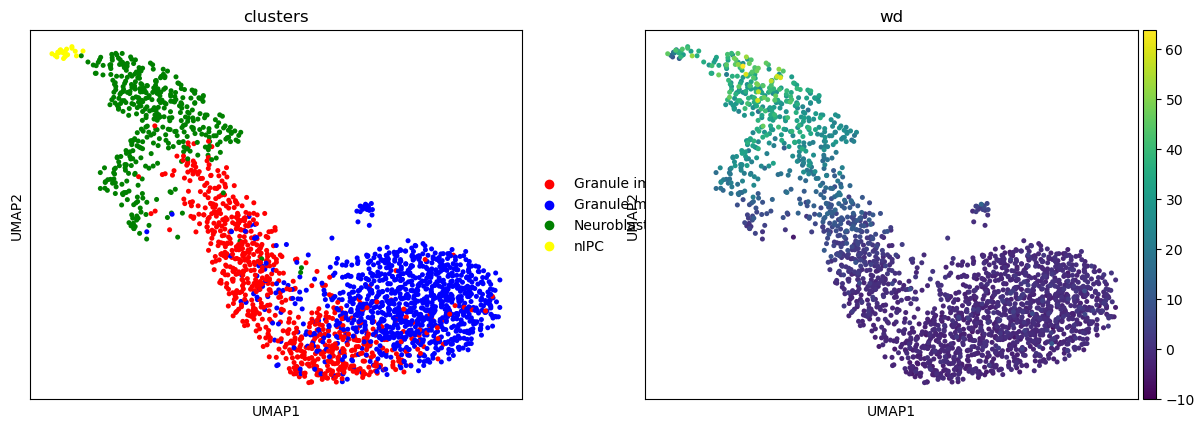

In [11]:
sc.pl.umap(adata, color=["clusters", "wd"])

In [12]:
import plotly.express as px
import pandas as pd

# Prepare data for plotting
df = pd.DataFrame({
    "UMAP1": adata.obsm["X_pca"][:, 0],
    "UMAP2": adata.obsm["X_pca"][:, 1],
    "Value": adata.obs["wd"]  # Replace with your column name
})

# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="UMAP1", y="UMAP2", z="Value",
    color="Value",  # Color by the numerical column
    color_continuous_scale="Viridis",  # Color map
    title="3D Plot: UMAP + Numerical Value"
)

fig.update_traces(marker=dict(size=1))  # Adjust marker size
fig.show()


In [44]:
import plotly.express as px
import pandas as pd

# Prepare data
df = pd.DataFrame({
    "UMAP1": adata.obsm["X_umap"][:, 0],
    "UMAP2": adata.obsm["X_umap"][:, 1],
    "ϕ (Potential)": adata.obs["wd"],  # Replace with your numerical column name
    "Cluster": adata.obs["clusters"].astype(str)  # Replace with your cluster column name
})

# Compute cluster centroids
centroids = df.groupby("Cluster")[["UMAP1", "UMAP2", "ϕ (Potential)"]].mean().reset_index()

# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="UMAP1", y="UMAP2", z="ϕ (Potential)",
    color="Cluster",  # Cluster-based coloring
    color_discrete_sequence=px.colors.qualitative.Set3,  # Color map
    title="Granule Cell Lineage",
)

# Add cluster labels at centroids
for _, row in centroids.iterrows():
    fig.add_scatter3d(
        x=[row["UMAP1"]],
        y=[row["UMAP2"]],
        z=[row["ϕ (Potential)"]],
        mode="text",
        text=[f"{row['Cluster']}"],
        textfont=dict(size=10, color="black", family="Arial"),
        showlegend=False
    )

fig.update_traces(marker=dict(size=1))  # Adjust marker size
fig.show()


In [45]:
fig.write_html("./granule_cell_3d.html")

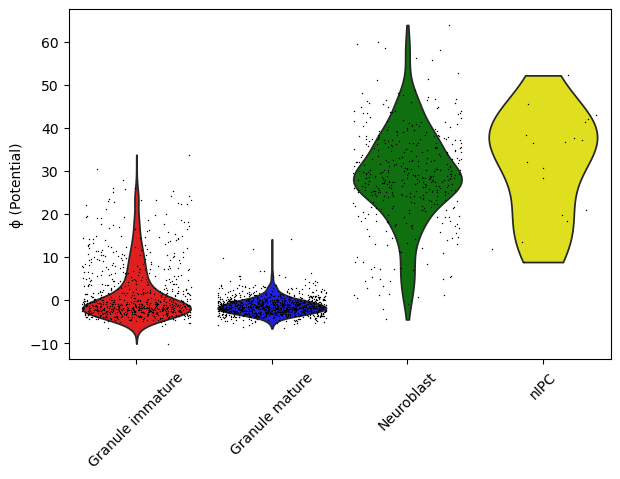

In [14]:
import scanpy as sc

# Assuming 'wd' is in adata.obs and 'celltype' is the category to group by
sc.pl.violin(adata, keys="wd", groupby="clusters", jitter=0.4, rotation=45, ylabel="ϕ (Potential)", save="mouse_violin.png")


/tmp/ipykernel_9550/3061708955.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9550/3061708955.py:14: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




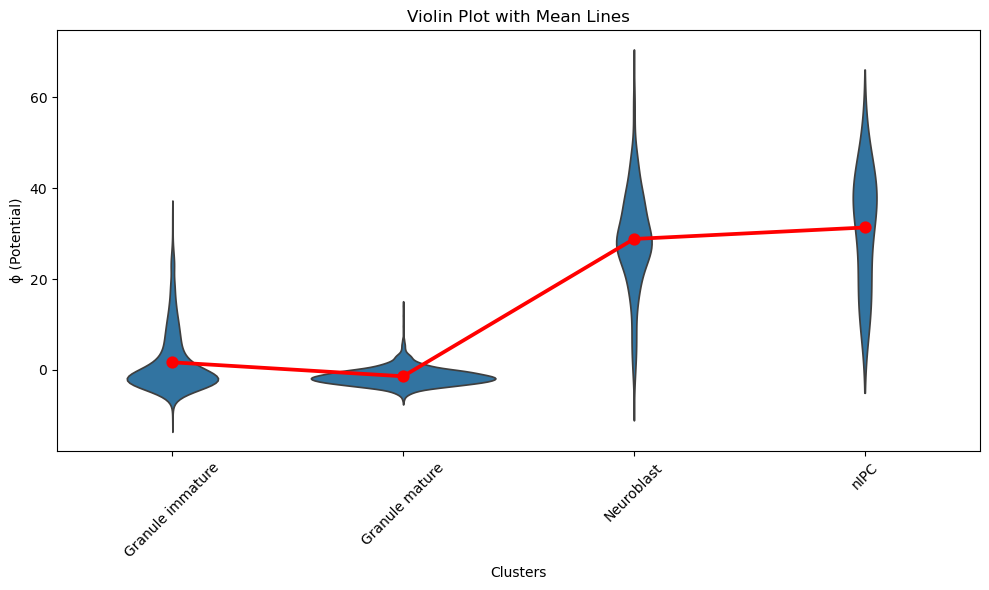

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract data
data = adata.obs[["wd", "clusters"]]

# Convert to a pandas DataFrame for easier handling
data["wd"] = data["wd"].astype(float)  # Ensure 'wd' is numeric if necessary

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x="clusters", y="wd", data=data, inner=None)  # No inner boxplots
sns.pointplot(x="clusters", y="wd", data=data, estimator="mean", color="red", ci=None)  # Mean line

# Customization
plt.ylabel("ϕ (Potential)")
plt.xlabel("Clusters")
plt.xticks(rotation=45)
plt.title("Violin Plot with Mean Lines")
plt.tight_layout()

# Save the plot
plt.savefig("mouse_violin_with_mean_lines.png", dpi=300)
plt.show()


/tmp/ipykernel_9550/3251477420.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9550/3251477420.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_9550/3251477420.py:20: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




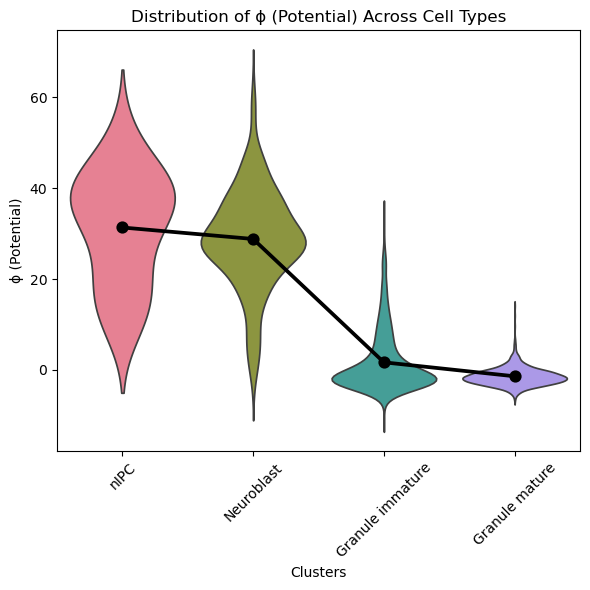

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract data
data = adata.obs[["wd", "clusters"]]

# Convert to a pandas DataFrame for easier handling
data["wd"] = data["wd"].astype(float)  # Ensure 'wd' is numeric if necessary

# Define custom order for clusters
custom_order = ["nIPC", "Neuroblast", "Granule immature", "Granule mature"]  # Replace with your desired order

# Define a custom color palette
palette = sns.color_palette("husl", n_colors=len(custom_order))  # Multicolored palette

# Plot using seaborn
plt.figure(figsize=(6, 6))
sns.violinplot(x="clusters", y="wd", data=data, inner=None, order=custom_order, palette=palette)  # Ordered and multicolored
sns.pointplot(
    x="clusters", y="wd", data=data, estimator="mean", ci=None, color="black", order=custom_order
)  # Mean line in black

# Customization
plt.ylabel("ϕ (Potential)")
plt.xlabel("Clusters")
plt.xticks(rotation=45)
plt.title("Distribution of ϕ (Potential) Across Cell Types")
plt.tight_layout()

# Save the plot
plt.savefig("mouse_violin_with_mean_lines_multicolored.png", dpi=300)
plt.show()


/tmp/ipykernel_9550/2350112820.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_9550/2350112820.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_9550/2350112820.py:19: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.

/tmp/ipykernel_9550/2350112820.py:19: FutureWarning:



The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=1`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.


/tmp/ipyker

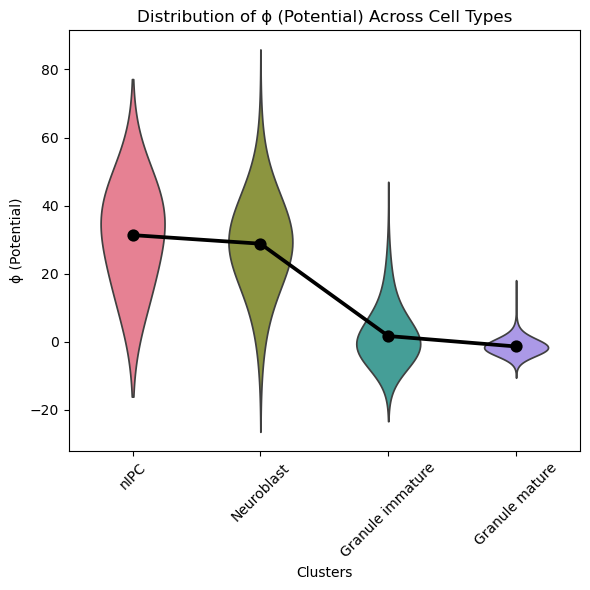

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract data
data = adata.obs[["wd", "clusters"]]

# Convert to a pandas DataFrame for easier handling
data["wd"] = data["wd"].astype(float)  # Ensure 'wd' is numeric if necessary

# Define custom order for clusters
custom_order = ["nIPC", "Neuroblast", "Granule immature", "Granule mature"]  # Replace with your desired order

# Define a custom color palette
palette = sns.color_palette("husl", n_colors=len(custom_order))  # Multicolored palette

# Plot using seaborn
plt.figure(figsize=(6, 6))
sns.violinplot(
    x="clusters",
    y="wd",
    data=data,
    inner=None,
    order=custom_order,
    palette=palette,
    scale="width",  # Scale by width for uniform appearance
    bw=1,  # Smoothing factor, lower makes violins thinner
    width=0.5,  # Thinner violins
)
sns.pointplot(
    x="clusters", y="wd", data=data, estimator="mean", ci=None, color="black", order=custom_order
)  # Mean line in black

# Customization
plt.ylabel("ϕ (Potential)")
plt.xlabel("Clusters")
plt.xticks(rotation=45)
plt.title("Distribution of ϕ (Potential) Across Cell Types")
plt.tight_layout()

# Save the plot
plt.savefig("mouse_violin_with_mean_lines_thinner.png", dpi=300)
plt.show()
